# Goals
- [x] Get ebird data from Alex
    - [x] US only (18g Feb17)
    - [ ] Update US data (18g Feb17 -> 20g May18) so it isn't a truncated gz
    - [ ] Try on global data (18g -> 29g -- turns out checklists are dominated by US)
- [ ] ebird.predict_proba(loc, date) -> probs
    - [x] Figure out how to aggregate to make data fit comfortably in mem
    - [x] Make an out-of-core ddf pass over the cols-for-time-space-priors.tsv file to produce the aggregates
    - [ ] Use the aggregates in memory to power the priors model
- [ ] Ensemble audio probs + ebird probs (expose tuning param for weighted combination)
- [ ] See how it improves model validation (e.g. many species should be way closer to few species)

In [ ]:
from notebooks import *

# Register a global dask progress bar
dask_progress().register()

relpath = os.path.relpath

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic


In [ ]:
# EbirdPriors params
ebird_priors = EbirdPriors(
    loc_binwidth='97mi', date_binwidth='4w',
)

In [ ]:
# Downsample raw data (in shell)
#   - TODO Downsample by checklist_id instead of line (one species within a checklist) to keep checklist (sampling
#     events) complete, else output priors are junk except for sample=1. This is nontrivial because we have to push the
#     full data volume through far enough to get checklist_id=coalesce(sampling_event_identifier, group_identifier)...
# (
#   set -eux
#   set -o pipefail
#   echo '
#     # 1              #  148m lines
#     # 1     .1 0.1   # 14.8m lines
#     # 0.1   .4 0.04  # 5.91m lines
#     # 0.04  .5 0.02  # 2.96m lines
#     # 0.1   .1 0.01  # 1.48m lines
#     # 0.01  .4 0.004 #  591k lines
#     # 0.004 .5 0.002 #  296k lines
#     # 0.01  .1 0.001 #  148k lines
#   ' | while read in_suf sample_frac out_suf comment; do
#     if [ -z "$in_suf" -o "$in_suf" = '#' ]; then continue; fi
#     raw_f='ebd_US_relFeb-2017.txt.gz'
#     in_f="$raw_f-$in_suf"; out_f="$raw_f-$out_suf"
#     cat "$in_f" \
#       | pv -terb -s"`du -Lhs "$in_f" | field 0`" -cN in \
#       | gunzip \
#       | sample-lines "$sample_frac" --seed=0 --keep-header \
#       | pigz \
#       | pv -terb -cN out \
#       > "$out_f"
#   done
# )

In [ ]:
# Inspect raw data
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz'        #  18gb,  148m lines
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.1'    # 778mb, 14.8m lines
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.01'   # 100mb, 1.48m lines
ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.001'  #  12mb,  148k lines
proj_cols = [
    'CATEGORY', 'SCIENTIFIC NAME', 'OBSERVATION COUNT', 'COUNTY CODE', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE',
    'SAMPLING EVENT IDENTIFIER', 'ALL SPECIES REPORTED',
]
ebd_tsv_df = pd.read_csv(ebd_tsv_path, sep='\t', nrows=10000, compression='gzip')
display(
    humanize.naturalsize(len(joblib_dumps(ebd_tsv_df))),
    humanize.naturalsize(len(joblib_dumps(ebd_tsv_df[proj_cols]))),
    # df_summary(ebd_tsv_df).T,
    df_summary(ebd_tsv_df[proj_cols]).T,
)

'9.9 MB'

'1.5 MB'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
index,int64,80000,10000,10000,10000,NaN,NaN,0,2499,4999,7499,9999
CATEGORY,object,639319,10000,10000,7,NaN,NaN,domestic,species,species,species,spuh
SCIENTIFIC NAME,object,746281,10000,10000,608,NaN,NaN,Acanthis flammea,Charadrius semipalmatus,Lophodytes cucullatus,Sayornis phoebe,Zosterops japonicus
OBSERVATION COUNT,object,651101,10000,10000,163,NaN,NaN,1,1,3,X,X
COUNTY CODE,object,659150,10000,9975,1316,NaN,NaN,US-AK-013,US-FL-105,US-MI-077,US-OR-003,US-WY-039
LATITUDE,float64,80000,10000,10000,5304,NaN,NaN,19.1,35.6,39.8,42.3,71.4
LONGITUDE,float64,80000,10000,10000,5303,NaN,NaN,-172,-107,-88.1,-77.7,173
OBSERVATION DATE,object,670000,10000,10000,5557,NaN,NaN,1800-01-01,1989-04-30,1998-03-15,2002-06-15,2004-12-31
SAMPLING EVENT IDENTIFIER,object,655180,10000,10000,9883,NaN,NaN,S1000381,S16318134,S25555972,S4519111,S9998747


In [ ]:
# Convert ebd.txt -> proj.tsv (in shell)
#   - ~10x faster to read than raw data: no gunzip + fewer cols
# (
#   set -eux
#   set -o pipefail
#   sufs=(
#     # 0.001
#     # 0.002
#     # 0.004
#     # 0.01
#     # 0.02
#     # 0.04
#     # 0.1
#     # 1
#   )
#   for suf in "${sufs[@]}"; do
#     in_f="ebd_US_relFeb-2017.txt.gz-$suf"
#     out_f="derived/priors/ebd_US_relFeb-2017-1-proj.tsv-$suf"
#     cat "$in_f" \
#       | pv -terb -cN in -s"`du -Lhs "$in_f" | field 0`" \
#       | gunzip \
#       | cut -f4,6,9,17,25,26,27,32,39,40 \
#       | pv -terb -cN out \
#       > "$out_f"
#   done
# )

In [ ]:
# FIXME ebd_US_relFeb-2017.txt.gz looks truncated (maybe the original download didn't complete?)
#
#   # Convert ebd.txt -> proj.tsv (in shell)
#   $ ...
#   + in_f=ebd_US_relFeb-2017.txt.gz-1
#   + out_f=derived/priors/ebd_US_relFeb-2017-0-proj.tsv-1
#   ...
#         out: 11.6GiB 0:13:21 [11.3MiB/s]
#         out: 11.6GiB 0:13:21 [14.9MiB/s]
#   gunzip: (stdin): unexpected end of file
#
#   $ tail -3 derived/priors/ebd_US_relFeb-2017-0-proj.tsv-1
#   species Regulus calendula       2       US-OR-067       45.546725       -122.9678249    2012-03-07      S10112003       1
#   species Recurvirostra americana 13      US-UT-053       37.1810055      -113.7148046    2012-03-18      S10208648       0
#   species Passer domesticus       5       US-WI-097       44.4993598      -89.5568454     2012-01-19      S96324

In [ ]:
# %%snakeviz
# %%prun -l50 -scumtime
# Compute priors[loc_bin, date_bin, sci_name, n_present, n] <- priors[sci_name, loc, date]
#   - (loc_bin, date_bin): cheap map-side operations
#   - n_present: mid-weight groupby agg
#   - n: heavy windowed agg [overall bottleneck, super-linear]
# Resources:
#   - http://dask.pydata.org/en/latest/dataframe-api.html
#   - http://dask.pydata.org/en/latest/dataframe-performance.html
#   - http://dask.pydata.org/en/latest/dataframe.html
#   - http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.set_index

# sample = 1      #  148m lines,  18gb input, no_chk[?],    chk[1512  + 3713s]
# sample = 0.1    # 14.8m lines, 778mb input, no_chk[?],    chk[ 153  +   87s]
# sample = 0.04   # 5.91m lines, 350mb input, no_chk[?],    chk[?]
# sample = 0.02   # 2.96m lines, 189mb input, no_chk[?],    chk[?]
# sample = 0.01   # 1.48m lines, 100mb input, no_chk[19s],  chk[  16  +    5.0s]
# sample = 0.004  #  591k lines,  43mb input, no_chk[?],    chk[?]
# sample = 0.002  #  296k lines,  23mb input, no_chk[?],    chk[?]
sample = 0.001  #  148k lines,  12mb input, no_chk[2.1s], chk[  1.6 +    0.6s]

ebd_proj_size = 12 * 1024**3
ebd_proj_npartitions = 128
proj_path     = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-1-proj.tsv-{sample}')
setindex_path = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-2-chk-setindex.parquet-{sample}')
priors_path   = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-{sample}')
priors = (

    # Read proj.tsv (raw lines with subset of cols)
    #   - sample=0.001: 148k rows, 12mb
    dd.read_csv(
        proj_path,
        # TODO Tune partitions
        # blocksize=int(ebd_proj_size / ebd_proj_npartitions * sample),
        # blocksize=int(ebd_proj_size / ebd_proj_npartitions * sample * 10),
        # blocksize=int(ebd_proj_size / ebd_proj_npartitions * sample * 100),
        blocksize=int(ebd_proj_size / ebd_proj_npartitions / 10),  # TODO This seems to work ok...?
        sep='\t',
        dtype={
            # lonlat decimal precision [https://en.wikipedia.org/wiki/Decimal_degrees]
            #   - float32: ~5-6 decimals, ~.1-1m
            #   - float16: ~1-2 decimals, ~1-10km
            'LATITUDE': 'float32',
            'LONGITUDE': 'float32',
            'OBSERVATION COUNT': 'str',  # int | 'X'
            'ALL SPECIES REPORTED': 'float16',  # Smallest dtype for {1, 0, None}
        },
    )
    # .pipe(puts, lambda ddf: 'len[%s]: read_csv' % len(ddf))  # Debug

    # Inspect [high-level perf debugging]
    .pipe(df_inspect, f'\n[read: {proj_path}]', lambda ddf: (
        f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        ddf.reset_index().dtypes.to_frame().T,
        # Heavy [high-level perf debugging]
        # '  [memory_usage by partition]',
        # (ddf
        #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     .compute()
        #     .pipe(df_with_totals).reset_index()[:50]
        #     # TODO Add a dtype col to the memory_usage outputs
        #     # .pipe(lambda df: pd.concat(axis=1, objs=[
        #     #     df,
        #     #     ddf.reset_index().dtypes.to_frame().rename({'index': 'Index'}),  # TODO Make this not reorder the index
        #     # ]))
        # ),
    ))

    # Simplify col names
    .rename(columns=lambda c: c.lower().replace(' ', '_'))

    # Drop cols we don't need
    .drop(axis=1, labels=['county_code'])

    # Keep obs with well defined species [https://help.ebird.org/customer/portal/articles/1006825]
    #   - sample=0.001: 144k rows
    .pipe(lambda ddf: ddf[ddf.category.isin(['species', 'domestic', 'issf', 'form'])])
    .drop(axis=1, labels=['category'])
    # .pipe(puts, lambda ddf: 'len[%s]: categories.isin' % len(ddf))  # Debug

    # Keep obs from checklists that represent a complete sampling of all present species
    #   - sample=0.001: 125k rows
    .pipe(lambda ddf: ddf[ddf.all_species_reported == 1])
    .drop(axis=1, labels=['all_species_reported'])
    # .pipe(puts, lambda ddf: 'len[%s]: all_species_reported' % len(ddf))  # Debug

    # Map (sampling_event_identifier, group_identifier) -> checklist_id
    #   - sample=0.001: 125k rows
    #   - Compress from str to int32 ('S10150441' -> 10150441) for ~46% compression (e.g. 24mb -> 13mb)
    #   - Map sampling_event_identifier to pos ('S10150441' -> 10150441) and group_identifier to net ('G554362' -> -554362)
    #   - FIXME Some of these nulls are due to misaligned fields (maybe something funny in the tsv? nontrivial problem -- punt)
    .dropna(subset=['sampling_event_identifier'])
    .assign(checklist_id=lambda ddf: (ddf
        .group_identifier.combine_first(ddf.sampling_event_identifier)
        .str.replace('S', '').str.replace('G', '-').astype(np.int32)
    ))
    .drop(axis=1, labels=['sampling_event_identifier', 'group_identifier'])
    # .pipe(puts, lambda ddf: 'len[%s]: checklist_id' % len(ddf))  # Debug

    # Map (lat, lon) -> loc_bin
    #   - sample=0.001: 125k rows
    .dropna(subset=['latitude', 'longitude'])
    .pipe(lambda ddf: ddf.map_partitions(
        meta=ddf._meta.assign(
            loc_bin='',
        ),
        func=lambda df: df.assign(
            loc_bin=lambda df: np.vectorize(ebird_priors._loc_bin, otypes=[str])(df.latitude, df.longitude),
        ),
    ))
    .drop(axis=1, labels=['latitude', 'longitude'])
    # .pipe(puts, lambda ddf: 'len[%s]: loc_bin' % len(ddf))  # Debug

    # Keep obs with >0 observation_count (including 'X')
    #   - sample=0.001: 125k rows
    .pipe(lambda ddf: ddf[ddf.observation_count != '0'])
    .drop(axis=1, labels=['observation_count'])
    # .pipe(puts, lambda ddf: 'len[%s]: observation_count' % len(ddf))  # Debug

    # Assert our cols and drop any remaining nulls
    #   - sample=0.001: 125k rows
    .pipe(tap, lambda ddf: assert_(
        ddf.columns.tolist() == ['scientific_name', 'observation_date', 'checklist_id', 'loc_bin'],
        'Unexpected cols: %s' % ddf.columns.tolist(),
    ))
    .dropna()
    # .pipe(puts, lambda ddf: 'len[%s]: dropna' % len(ddf))  # Debug

    # Map observation_date:str -> observation_date_bin:uint8
    #   - (category would be more compact than uint32/64 in the .parquet, but that ran into problems -- abort)
    .assign(
        observation_date=lambda df: pd.to_datetime(df.observation_date),
        # date_bin=lambda df: df.observation_date.map(ebird_priors._date_bin),  # TODO Vectorize (over df.observation_date.dt)
        date_bin=lambda df: np.vectorize(ebird_priors._date_bin, otypes=[int])(df.observation_date.dt),
    )
    .astype({'date_bin': np.uint8})
    .drop(axis=1, labels=['observation_date'])

    # Create categories to compact space usage via dictionary encoding
    #   - WARNING Have to recreate category dtypes after munging meta, else downstream .to_parquet fails on `pd.Index(None)`
    .astype({
        'scientific_name': 'category',
        'loc_bin': 'category',  # Max 32**4 = ~1m values -> ~4mb dictionary (separate dictionary per partition df)
    })

    # Inspect [high-level perf debugging]
    .pipe(df_inspect,
        '\n[map-side ops]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        lambda ddf: ddf.reset_index().dtypes.to_frame().T,
        # '  [memory_usage by partition]',
        # lambda ddf: (ddf
        #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     .compute()
        #     .pipe(df_with_totals).reset_index()[:50]
        # ),
    )

    # .set_index to partition once to avoid 3 shuffles below (drop_duplicates, groupby, groupby)
    #   - ddf.set_index doesn't support multiple cols, so add dist_key = hash(loc_bin, date_bin)
    #   - Hash to uint16 for ≤64k partitions [alt: ≤256 for uint8]
    #   - [wontfix] uint16 gets unavoidably widened to uint64 by df.set_index [https://github.com/pandas-dev/pandas/issues/16404]
    .assign(dist_key=lambda df: (
        np_vectorize_asscalar(otypes=[np.uint16], pyfunc=lambda loc_bin, date_bin: (
            one(np.frombuffer(
                dtype=np.uint16,
                buffer=hashlib.sha1(f'{loc_bin}/{date_bin}'.encode('utf8')).digest()[:2],
            ))
        ))(df.loc_bin, df.date_bin)
    ))
    #   - Checkpoint before .set_index
    #       - Why helpful: the timing numbers above show a clean time-complexity split of linear before the chk and super-linear after
    .pipe(df_inspect, f'\n[checkpointing before set_index: {setindex_path}]')
    .pipe(ddf_checkpoint, setindex_path, compression=None,
        get=dask_get_for_scheduler('threads'),  # Procs no good [TODO why?]
        # resume_from_checkpoint=True,  # Re-comment out after measuring perf of .set_index
    )
    .pipe(df_inspect,
        f'\n[checkpointed before set_index: {setindex_path}]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        lambda ddf: ddf.reset_index().dtypes.to_frame().T,
        # Heavy [high-level perf debugging]
        # '  [memory_usage by partition]',
        # lambda ddf: (ddf
        #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     .compute()
        #     .pipe(df_with_totals).reset_index()[:50]
        # ),
    )
    #   - Finally do the .set_index
    .pipe(lambda ddf: (ddf
        .set_index('dist_key', divisions=ddf_divisions_for_dtype(ddf.dist_key.dtype,
            # TODO TODO Tune npartitions for groupby's
            # ddf.npartitions,
            # 1,   # sync+prun: 0.01[4.7s]
            # 2,   # sync+prun: 0.01[4.6s]
            # 5,   # sync+prun: 0.01[4.6s]
            10,  # sync+prun: 0.01[5.1s]
            # 20,  # sync+prun: 0.01[6.1s]
            # 40,  # sync+prun: 0.01[8.1s]
        ))
    ))
    #   - HACK Recreate category dtypes after the .set_index, else downstream .to_parquet fails on `pd.Index(None)`
    .pipe(lambda ddf: (ddf
        .astype({k: 'category' for k, v in ddf.dtypes.items() if v.name == 'category'})
    ))

    # Inspect [high-level perf debugging]
    .pipe(df_inspect,
        '\n[set_index(dist_key)]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        lambda ddf: ddf.reset_index().dtypes.to_frame().T,
        # '  [memory_usage by partition]',
        # lambda ddf: (ddf
        #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     .compute()
        #     .pipe(df_with_totals).reset_index()[:50]
        # ),
    )

    # Do a bunch of map-side groupby's via .map_partitions, relying on the .set_index we just did
    .map_partitions(lambda df: (df

        # Drop duplicate rows since all (checklist, species) should be unique
        #   - sample=0.001: 142k -> 98.7k rows
        #   - Some dupes come from group_identifier vs. sampling_event_identifier: anything with group_identifier is repeated
        #   - Also, the sample=0.001 raw file shows most lines occur once but ~18 lines are repeated ~2500-2800 times <- definitely junk
        .drop_duplicates(
            subset=['loc_bin', 'date_bin', 'scientific_name', 'checklist_id'],
            keep='first',
        )

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: drop_duplicates]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

        # Compute n (window)
        #   - Num unique checklist_id's per (loc_bin, date_bin)
        #   - WARNING observed=True else groupby blows up all loc_bin.cat x scientific_name.cat, which is way too much
        #   - This assign-by-index is the bottleneck (way slower than the groupby for n_present)
        #       - See cell below for attempts at optimizing -- haven't found any faster approaches yet...
        .reset_index()  # dist_key, from ddf.map_partitions
        .set_index(['dist_key', 'loc_bin', 'date_bin'])
        .assign(n=lambda df: (df
            .groupby(observed=True, by=['dist_key', 'loc_bin', 'date_bin'])
            .checklist_id.nunique()
            .astype(np.uint32)  # TODO uint16 to save space? -- measure max in the data? Or just drop this col entirely?
        ))

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: n]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

        # Compute n_present (group)
        #   - Num checklists per (loc_bin, date_bin, scientific_name)
        #   - WARNING observed=True else groupby blows up all loc_bin.cat x scientific_name.cat, which is way too much
        .assign(n_present=1)  # One per (loc_bin, date_bin, scientific_name, checklist_id)
        .groupby(observed=True, by=['dist_key', 'loc_bin', 'date_bin', 'scientific_name'])
        .agg({
            'n_present': 'sum',
            'n': 'first',  # Passthru; assume unique per group
            # Drop: checklist_id
        })

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: n_present -> p]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

        # XXX Keep (n_present, n) for simpler query-time aggregation
        # # Compute p, drop n_present
        # .assign(p=lambda df: (
        #     (df.n_present / df.n)
        #     .astype('float16')  # TODO uint8?
        #     # FIXME This turns into float32 after to_parquet
        #     #   - parquet doesn't support float16, so maybe it's getting coerced? [https://drill.apache.org/docs/parquet-format/]
        #     #   - TODO But does fastparquet read not re-cast to the dtype the .parquet file was written from?
        # ))
        # .drop(columns=['n_present'])
        # .pipe(df_reorder_cols, last=['n'])

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: p]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

        # Restore dtypes lost in the index by the groupby's above (e.g. date_bin: uint8 -> uint64)
        .reset_index()
        .astype({
            'date_bin': 'uint8',
        })

        # Restore ['dist_key'] index for ddf.map_partitions
        .set_index(['dist_key'])

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: set_index]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

    ))

    # Inspect [high-level perf debugging]
    .pipe(df_inspect,
        f'\n[map_partitions]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        lambda ddf: ddf.reset_index().dtypes.to_frame().T,
    )

    # Write
    #   - TODO df.to_parquet instead of ddf.to_parquet, since these files are only O(100mb) and ddf output isn't
    #     readable by pd, and pd.read_parquet() is ~15–30x faster than dd.read_parquet().compute()
    #   - Measurements for dd.read_parquet().compute() vs. pd.read_parquet()
    #       - sample = 1      # 330mb parquet, 177mb df,  13m rows, 8.0s ddf.read, .24s   df.read (!)
    #       - sample = 0.1    # 100mb parquet,  57mb df, 4.2m rows, 1.1s ddf.read, .069s  df.read
    #       - sample = 0.01   #  31mb parquet,  12mb df, 730k rows, .19s ddf.read, .0095s df.read
    #       - sample = 0.001  #   6mb parquet, 3.2mb df,  85k rows, .15s ddf.read, .0046s df.read
    .pipe(df_inspect, f'\n[write: {priors_path}]')
    .pipe(ddf_checkpoint, priors_path,
        compression=None,
        # get=dask_get_for_scheduler('synchronous'),  # Debug
        get=dask_get_for_scheduler('threads'),  # Faster
        # get=dask_get_for_scheduler('processes'),
    )

    # Inspect [high-level perf debugging]
    .pipe(df_inspect,
        f'\n[inspect priors: {priors_path}]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        # Heavy [high-level perf debugging]
        '  [memory_usage by partition]',
        lambda ddf: (ddf
            .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
            .compute()
            .pipe(df_with_totals).reset_index()[:50]
        ),
    )
    .pipe(tap, lambda ddf: (ddf
        .head(10000)
        .pipe(df_inspect,
            lambda df: df_summary(df).T,
            lambda df: df[:10],
        )
    ))

)


[read: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-1-proj.tsv-0.001]

'npartitions[2], divisions[(None, None, None)]'

,index,CATEGORY,SCIENTIFIC NAME,OBSERVATION COUNT,COUNTY CODE,LATITUDE,LONGITUDE,OBSERVATION DATE,SAMPLING EVENT IDENTIFIER,ALL SPECIES REPORTED,GROUP IDENTIFIER
0,int64,object,object,object,object,float32,float32,object,object,float16,object



[map-side ops]

npartitions[2], divisions[(None, None, None)]

,index,scientific_name,checklist_id,loc_bin,date_bin
0,int64,category,int32,category,uint8



[checkpointing before set_index: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-2-chk-setindex.parquet-0.001]

[                                                                                          ] | 0% Completed |  0.0s

[######################                                                                    ] | 24% Completed |  0.1s

[####################################                                                      ] | 40% Completed |  0.3s

[############################################                                              ] | 49% Completed |  0.4s

[#########################################################                                 ] | 63% Completed |  0.5s

[###############################################################                           ] | 70% Completed |  0.6s

[###################################################################                       ] | 75% Completed |  0.7s

[###################################################################                       ] | 75% Completed |  0.8s

[############################################################################              ] | 85% Completed |  1.0s

[##################################################################################        ] | 91% Completed |  1.1s

[####################################################################################      ] | 93% Completed |  1.2s

[####################################################################################      ] | 93% Completed |  1.3s

[####################################################################################      ] | 93% Completed |  1.4s

[####################################################################################      ] | 93% Completed |  1.5s

[#####################################################################################     ] | 95% Completed |  1.6s

[##########################################################################################] | 100% Completed |  1.8s


[checkpointed before set_index: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-2-chk-setindex.parquet-0.001]

npartitions[2], divisions[(None, None, None)]

,index,scientific_name,checklist_id,loc_bin,date_bin,dist_key
0,int64,category,int32,category,uint8,uint16



[set_index(dist_key)]

npartitions[10], divisions[(0, 6553, 13107, 19660, 26214, 32767, 39321, 45874, 52428, 58981, 65535)]

,dist_key,scientific_name,checklist_id,loc_bin,date_bin
0,uint64,category,int32,category,uint8



[map_partitions]

npartitions[10], divisions[(0, 6553, 13107, 19660, 26214, 32767, 39321, 45874, 52428, 58981, 65535)]

,dist_key,loc_bin,date_bin,scientific_name,n_present,n
0,uint64,category,uint8,category,int64,uint32



[write: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-0.001]

[                                                                                          ] | 0% Completed |  0.0s

[#                                                                                         ] | 1% Completed |  0.1s

[#                                                                                         ] | 1% Completed |  0.2s

[#                                                                                         ] | 1% Completed |  0.4s

[#                                                                                         ] | 1% Completed |  0.5s

[#                                                                                         ] | 1% Completed |  0.6s

[#                                                                                         ] | 1% Completed |  0.7s

[#                                                                                         ] | 1% Completed |  0.8s

[#                                                                                         ] | 1% Completed |  0.9s

[#                                                                                         ] | 1% Completed |  1.0s

[#                                                                                         ] | 1% Completed |  1.1s

[#####                                                                                     ] | 6% Completed |  1.2s

[#####                                                                                     ] | 6% Completed |  1.3s

[######################                                                                    ] | 25% Completed |  1.4s

[###############################################                                           ] | 53% Completed |  1.5s

[###############################################                                           ] | 53% Completed |  1.7s

[###############################################                                           ] | 53% Completed |  1.8s

[###############################################                                           ] | 53% Completed |  1.9s

[##################################################################################        ] | 91% Completed |  2.0s

[##########################################################################################] | 100% Completed |  2.1s


[inspect priors: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-0.001]

npartitions[10], divisions[(5, 6557, 13133, 19673, 26233, 32775, 39324, 45875, 52444, 59008, 65535)]

  [memory_usage by partition]

[                                                                                          ] | 0% Completed |  0.0s

[##########################################################################################] | 100% Completed |  0.1s

,index,Index,loc_bin,date_bin,scientific_name,n_present,n,total
0,0,54320,32960,6790,54497,54320,27160,230047
1,0,49520,30440,6190,50674,49520,24760,211104
2,0,50736,47004,6342,66453,50736,25368,246639
3,0,47128,46102,5891,65551,47128,23564,235364
4,0,48040,31090,6005,48888,48040,24020,206083
5,0,46840,46030,5855,65479,46840,23420,234464
6,0,46208,30452,5776,50432,46208,23104,202180
7,0,46384,29536,5798,50125,46384,23192,201419
8,0,52768,30772,6596,51322,52768,26384,220610
9,0,51872,31088,6484,50869,51872,25936,218121


[                                                                                          ] | 0% Completed |  0.0s

[##########################################################################################] | 100% Completed |  0.1s

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/dask/dataframe/core.py:4206: UserWarning: Insufficient elements for `head`. 10000 elements requested, only 6790 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dist_key,uint64,54320,6790,6790,492,3178.392,1962.351,5,1548,3224,4976,6551
loc_bin,category,43200,6790,6790,323,NaN,NaN,87y,9ud,c20,dp4,zc7
date_bin,uint8,6790,6790,6790,12,20.738,13.260,0,12,20,32,44
scientific_name,category,74977,6790,6790,546,NaN,NaN,Acanthis flammea,Charadrius vociferus,Megascops asio,Regulus satrapa,Zosterops japonicus
n_present,int64,54320,6790,6790,10,1.357,0.829,1,1,1,1,10
n,uint32,27160,6790,6790,83,54.901,49.635,1,14,39,91,233


,loc_bin,date_bin,scientific_name,n_present,n
dist_key,,,,,
5,c1f,32,Brachyramphus marmoratus,1,3
5,c1f,32,Passerculus sandwichensis,1,3
5,c1f,32,Sturnus vulgaris,1,3
6,9vq,4,Poecile carolinensis,2,20
6,9vq,4,Anhinga anhinga,1,20
6,9vq,4,Ardea herodias,2,20
6,9vq,4,Zenaida macroura,2,20
6,9vq,4,Agelaius phoeniceus,1,20
6,9vq,4,Cardinalis cardinalis,1,20


In [ ]:
# Inspect priors[loc_bin, date_bin, sci_name, n_present, n]
(priors
    .head(1_000_000)
    .pipe(df_inspect,
        lambda df: df_summary(df).T,
        lambda df: df[:10],
    )
);

[                                                                                          ] | 0% Completed |  0.0s

[##########################################################################################] | 100% Completed |  0.1s

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/dask/dataframe/core.py:4206: UserWarning: Insufficient elements for `head`. 1000000 elements requested, only 6790 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dist_key,uint64,54320,6790,6790,492,3178.392,1962.351,5,1548,3224,4976,6551
loc_bin,category,43200,6790,6790,323,NaN,NaN,87y,9ud,c20,dp4,zc7
date_bin,uint8,6790,6790,6790,12,20.738,13.260,0,12,20,32,44
scientific_name,category,74977,6790,6790,546,NaN,NaN,Acanthis flammea,Charadrius vociferus,Megascops asio,Regulus satrapa,Zosterops japonicus
n_present,int64,54320,6790,6790,10,1.357,0.829,1,1,1,1,10
n,uint32,27160,6790,6790,83,54.901,49.635,1,14,39,91,233


,loc_bin,date_bin,scientific_name,n_present,n
dist_key,,,,,
5,c1f,32,Brachyramphus marmoratus,1,3
5,c1f,32,Passerculus sandwichensis,1,3
5,c1f,32,Sturnus vulgaris,1,3
6,9vq,4,Poecile carolinensis,2,20
6,9vq,4,Anhinga anhinga,1,20
6,9vq,4,Ardea herodias,2,20
6,9vq,4,Zenaida macroura,2,20
6,9vq,4,Agelaius phoeniceus,1,20
6,9vq,4,Cardinalis cardinalis,1,20


In [ ]:
# Convert priors_ddf.parquet -> priors_df.parquet
#   - TODO Push this upstream? Or faster to iterate if we keep the heavy step (n_present, n) as simple as possible?
#   - pd.read_parquet isn't happy with hive-style ddf.to_parquet formats, so manually convert into a pd-friendly format
# sample = 1      #  148m txt.gz lines,  18gb txt.gz, 330mb parquet, 177mb df,  13m rows, 4.9s read_parquet,  18s total, 205mb out
# sample = 0.1    # 14.8m txt.gz lines, 778mb txt.gz, 100mb parquet,  57mb df, 4.2m rows,  .6s read_parquet, 4.2s total,  64mb out
# sample = 0.01   # 1.48m txt.gz lines, 100mb txt.gz,  31mb parquet,  12mb df, 730k rows,  .1s read_parquet, 1.0s total,  12mb out
sample = 0.001  #  148k txt.gz lines,  12mb txt.gz,   6mb parquet, 3.2mb df,  85k rows,  .1s read_parquet,  <1s total, 1.7mb out
priors_path = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-{sample}')
priors_df_path = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-4-priors-df.parquet-{sample}')
priors_df = (

    # Read ddf.parquet
    dd.read_parquet(puts(priors_path))

    # Materialize ddf -> df
    .pipe(tap, lambda df: log.info('Materializing ddf -> df...'))
    .compute()
    .reset_index(drop=True)  # Drop dist_key

    # Inspect
    .pipe(df_inspect, 'load', lambda df: (df_summary(df).T, df[:5]))

    # Write df.parquet
    .to_parquet(priors_df_path, compression=None)

)

features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-0.001


[00:04:50.751] INFO   Materializing ddf -> df...
[                                                                                          ] | 0% Completed |  0.0s

[##########################################################################################] | 100% Completed |  0.1s

load

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
index,int64,493816,61727,61727,61727,30863.000,17819.194,0,15431,30863,46294,61726
loc_bin,category,178254,61727,61727,572,NaN,NaN,87y,9x5,dp8,9qx,zc6
date_bin,uint8,61727,61727,61727,12,21.412,13.054,0,12,20,32,44
scientific_name,category,197703,61727,61727,716,NaN,NaN,Acanthis flammea,Chen caerulescens,Melanerpes carolinus,Setophaga americana,Vireo atricapilla
n_present,int64,493816,61727,61727,16,1.400,0.975,1,1,1,1,17
n,uint32,246908,61727,61727,192,58.435,68.945,1,14,33,80,469


,loc_bin,date_bin,scientific_name,n_present,n
0,c1f,32,Brachyramphus marmoratus,1,3
1,c1f,32,Passerculus sandwichensis,1,3
2,c1f,32,Sturnus vulgaris,1,3
3,9vq,4,Poecile carolinensis,2,20
4,9vq,4,Anhinga anhinga,1,20


In [ ]:
# %%snakeviz
# %%prun -l40 -scumtime
# %%timeit -r1 -n1
# Compute priors[ix:loc_bin, ix:date_bin, species, n_present, n] <- priors[loc_bin, date_bin, sci_name, n_present, n]
# sample = 1      #  148m txt.gz lines,  18gb txt.gz, 330mb parquet, 177mb df,  13m rows, 4.9s read_parquet,  37s total
# sample = 0.1    # 14.8m txt.gz lines, 778mb txt.gz, 100mb parquet,  57mb df, 4.2m rows,  .6s read_parquet,  11s total
# sample = 0.01   # 1.48m txt.gz lines, 100mb txt.gz,  31mb parquet,  12mb df, 730k rows,  .1s read_parquet, 1.7s total
sample = 0.001  #  148k txt.gz lines,  12mb txt.gz,   6mb parquet, 3.2mb df,  85k rows,  .1s read_parquet, .30s total
priors_df_path = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-4-priors-df.parquet-{sample}')
priors_df = (

    # Read df
    pd.read_parquet(puts(priors_df_path), engine='fastparquet')
    .reset_index(drop=True)  # Drop dist_key

    # Back compat [XXX after regenerating priors files with (n_present, n) instead of (p, n)]
    .pipe(lambda df: df if 'n_present' in df.columns else (df
        .assign(n_present=lambda df: (df.p * df.n).round().astype(np.int32))
        .drop(columns=['p'])
    ))

    # Join sci_name -> species
    #   - TODO Bottleneck, consider pushing upstream if we need to iterate faster here than there
    .pipe(tap, lambda df: log.info('Joining sci_name -> species...'))
    .rename(columns={'scientific_name': 'sci_name'})
    .assign(sci_name=lambda df: (df.sci_name
        # TODO Find a more systematic way to align the taxonomies (recent ebird api request vs. Feb17 ebird data dump)
        .str.replace(r' \(Domestic type\)$', '')
        .replace({
            'Anas americana': 'Mareca americana',  # American Wigeon
            'Anas clypeata': 'Spatula clypeata',  # Northern Shoveler
            'Anas cyanoptera': 'Spatula cyanoptera',  # Cinnamon Teal
            'Anas discors': 'Spatula discors',  # Blue-winged Teal
            'Anas falcata': 'Mareca falcata',  # Falcated Duck
            'Anas formosa': 'Sibirionetta formosa',  # Baikal Teal
            'Anas penelope': 'Mareca penelope',  # Eurasian Wigeon
            'Anas querquedula': 'Spatula querquedula',  # Garganey
            'Anas strepera': 'Mareca strepera',  # Gadwall
            'Chen caerulescens': 'Anser caerulescens',  # Snow Goose
            'Chen canagica': 'Anser canagicus',  # Emperor Goose
            'Chen rossii': 'Anser rossii',  # Ross's Goose
            'Larus thayeri': 'Larus glaucoides thayeri',  # Thayer's Gull [subspecies, won't match]
            'Porphyrio martinicus': 'Porphyrio martinica',  # Purple Gallinule (/ American Purple Gallinule)
            'Procelsterna cerulea': 'Anous ceruleus',  # Blue-gray Noddy (/ Blue Noddy)
            'Serinus mozambicus': 'Crithagra mozambica',  # Yellow-fronted Canary
        })
    ))
    .set_index('sci_name')
    .join(how='left', other=metadata.species.df[['sci_name', 'shorthand']].set_index('sci_name'))
    .reset_index()  # sci_name
    .rename(columns={'shorthand': 'species'})
    .pipe(df_reorder_cols, first=['species'])

    # Warn on unknown sci_name's
    .pipe(tap, lambda df: log.info("Checking for unknown sci_name's..."))
    .pipe(tap, lambda df: (df
        [['sci_name', 'species']]
        .drop_duplicates()
        .query('species.isnull()')
        .pipe(lambda df: None if df.empty else [
            log.warn("Unknown sci_name's in priors_df:"),
            display(df),
        ])
    ))
    .drop(columns=['sci_name'])  # Drop sci_name
    .dropna(subset=['species'])  # Drop unknown sci_name's

    # # Set index for query-time joins
    # #   - TODO Does anything benefit from this? -- delete if not
    # .pipe(tap, lambda df: log.info('Setting indexes for query-time joins...'))
    # .astype({'date_bin': 'category'})  # More compact than uint64
    # .set_index(['loc_bin', 'date_bin'])
    # # .sort_index()  # XXX Unnecessary bottleneck

    # Ergonomics
    .pipe(df_reorder_cols, first=['loc_bin', 'date_bin', 'species', 'n_present', 'n'])

    # Inspect
    .pipe(tap, lambda df: log.info('Inspecting...'))
    .pipe(df_inspect,
        lambda df: (df
            .reset_index().memory_usage(deep=True, index=False)
            .to_frame().pipe(df_with_totals_row).applymap(humanize.naturalsize)
        ),
        lambda df: df_summary(df.reset_index()).T,
        lambda df: df[:10],
    )

)

features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-4-priors-df.parquet-0.001
[00:04:51.228] INFO   Joining sci_name -> species...
[00:04:51.301] INFO   Checking for unknown sci_name's...
[00:04:51.322] WARN   Unknown sci_name's in priors_df:


,sci_name,species
28445,Larus glaucoides thayeri,nan


[00:04:51.336] INFO   Inspecting...


,0
index,493.7 kB
loc_bin,178.2 kB
date_bin,61.7 kB
species,1.1 MB
n_present,493.7 kB
n,246.9 kB
0,2.6 MB


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
level_0,int64,493728,61716,61716,61716,30857.500,17816.019,0,15428,30857,46286,61715
index,int64,493728,61716,61716,61716,30863.430,17820.753,0,15428,30868,46297,61726
loc_bin,category,178232,61716,61716,572,NaN,NaN,87y,9x5,dp8,9qx,zc6
date_bin,uint8,61716,61716,61716,12,21.410,13.053,0,12,20,32,44
species,category,1102520,61716,61716,713,NaN,NaN,BBWD,KILL,STJA,KEWA,JASP
n_present,int64,493728,61716,61716,16,1.400,0.975,1,1,1,1,17
n,uint32,246864,61716,61716,192,58.436,68.950,1,14,33,80,469


,loc_bin,date_bin,species,n_present,n
0,drd,8,CORE,1,22
1,b5m,32,CORE,1,15
2,c28,4,CORE,1,45
3,bem,24,CORE,1,4
4,f01,12,CORE,1,19
5,dp9,4,CORE,1,46
6,dp3,44,CORE,1,59
7,9zz,8,CORE,1,19
8,drs,4,CORE,1,29
9,dr9,8,CORE,1,123


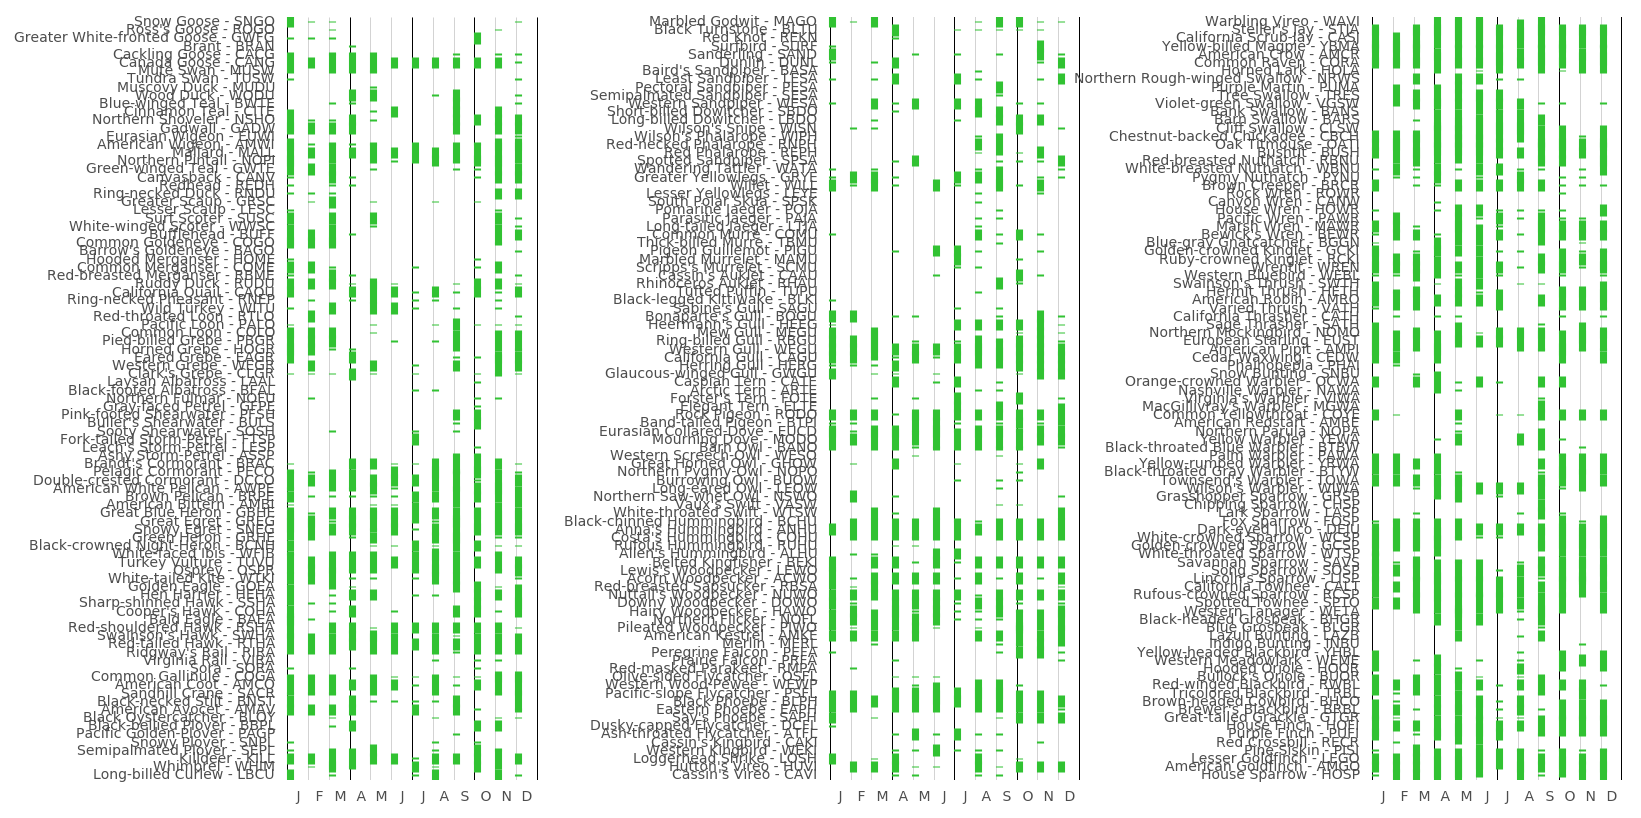

<ggplot: (300883271)>

In [ ]:
# Plot barcharts: priors[loc_bin==...][species, date_bin, p]
loc_bins = ebird_priors._loc_smooth(37.9, -122)  # Mt. Diablo ±1 (includes: SF, Berkeley hills, Mt Diablo, Marin)
(priors_df
    [lambda df: df.loc_bin.isin(loc_bins)]
    .pipe(ebird_species_probs, groupby=['species', 'date_bin'], agg=['loc_bin'])
    # .pipe(df_inspect, lambda df: (df.shape, df[:5]))
    .pipe(plot_barchart,
        # downsample_sp=30,  cols=1, width_per_col=4,    aspect_per_col=1.25,  # Good examle of 1 col
        # downsample_sp=30,  cols=3, width_per_col=14/3, aspect_per_col=0.278, # Great (better than 2 col)
        # downsample_sp=90,  cols=3, width_per_col=14/3, aspect_per_col=0.833, # Great (better than 2 col)
        # downsample_sp=170, cols=3, width_per_col=14/3, aspect_per_col=1.07,  # Great
        # downsample_sp=250, cols=4, width_per_col=5,    aspect_per_col=1.04,  # Great (width 18-22)
        # downsample_sp=300, cols=5, width_per_col=24/5, aspect_per_col=1.00,  # Great (almost full on sp)
        # downsample_sp=415, cols=6, width_per_col=4,    aspect_per_col=1.15,  # Good (room for more sp)
    )
)

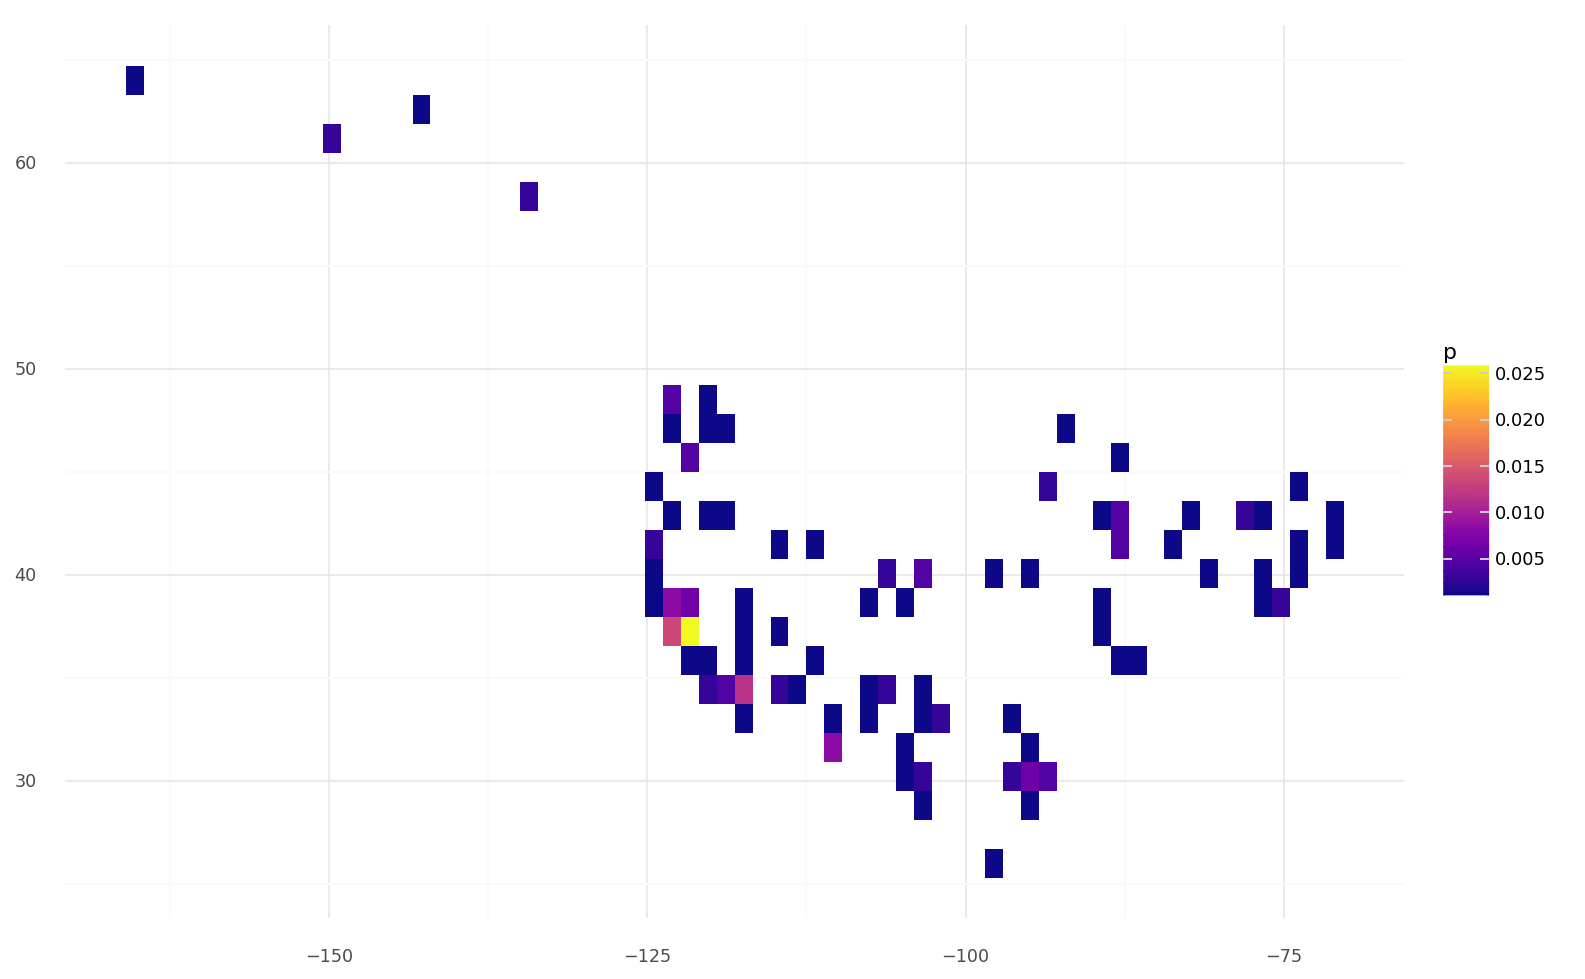

<ggplot: (301705953)>

In [ ]:
# Plot species maps: priors[species==...][lat, lon, p]
species = ['WIWA']
(priors_df
    [lambda df: df.species.isin(species)]
    .pipe(ebird_species_probs, groupby=['loc_bin'], agg=['species', 'date_bin'])
    .assign(
        w=lambda df: df.loc_bin.map(lambda x: geoh.str_bbox(x, ebird_priors._loc_binwidth_geohash_precision_bits)['w']),
        e=lambda df: df.loc_bin.map(lambda x: geoh.str_bbox(x, ebird_priors._loc_binwidth_geohash_precision_bits)['e']),
        s=lambda df: df.loc_bin.map(lambda x: geoh.str_bbox(x, ebird_priors._loc_binwidth_geohash_precision_bits)['s']),
        n=lambda df: df.loc_bin.map(lambda x: geoh.str_bbox(x, ebird_priors._loc_binwidth_geohash_precision_bits)['n']),
    )
    # .pipe(df_inspect, lambda df: (df.shape, df[:5]))
    .pipe(ggplot)
    + aes(fill='p', xmin='w', xmax='e', ymin='s', ymax='n')
    + geom_bin2d(stat='identity')
    + scale_fill_cmap('plasma')
    + theme_minimal()
    + theme_figsize('inline')
)

In [ ]:
# How big is the (loc_bin, date_bin) key space?
(priors_df
    [['loc_bin', 'date_bin']]
    .drop_duplicates()
    .shape
)

(4813, 2)

In [ ]:
priors_df_sort = priors_df.sort_values(['loc_bin', 'date_bin'])

In [ ]:
x = (priors_df_sort
    # .pipe(df_inspect, lambda df: (df.shape, df[:10]))
    # [:1_000]
    # [:10_000]
    # [:100_000]
    [:1_000_000]
    # [:13_383_057]  # len(priors_df_sort)
    .pipe(tap, lambda df: print('limit: %s' % len(df)))
    .groupby(['loc_bin', 'date_bin'], sort=False)
    .pipe(lambda g: {
        # 1k[ 90ms 9.3k] 10k[.94s  82k] 100k[9.3s 800k] 1m[96s 8.2mb] 13.4m[TODO]
        k: SpeciesCounter(
            n=df['n'].iloc[0],
            sp=Counter({row.species: row.n_present for row in df_rows(df)}),
        )
        for k, df in g
    })
)
ipy_print(
    len(x),
)

limit: 61716


4813
